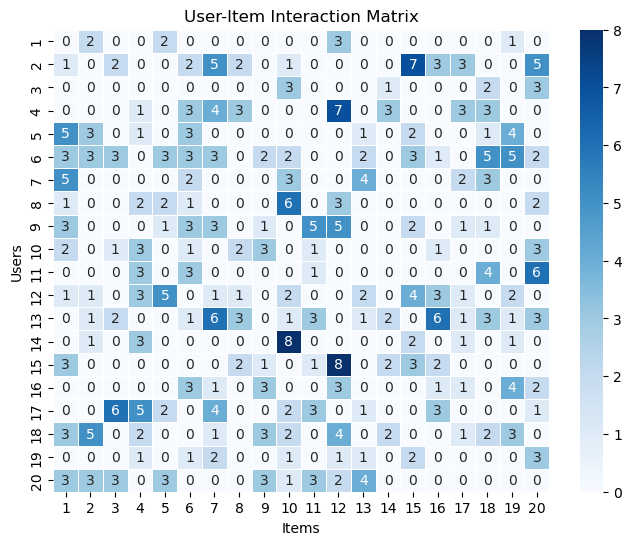

In [11]:
import pandas as pd
import numpy as np

def load_orders():
    # Load orders from CSV file
    orders_path = '../data/raw/orders.csv'
    order_items_path = '../data/raw/order_items.csv'
    
    # Read the CSV files
    orders = pd.read_csv(orders_path)
    order_items = pd.read_csv(order_items_path)
    
    # Merge orders with order items
    merged_orders = pd.merge(
        orders,
        order_items,
        on='order_id',
        how='inner'
    )
    
    return merged_orders

def user_item_matrix():
    orders = load_orders()
    
    # Create user-item matrix
    matrix = orders.pivot_table(
        index='user_id',
        columns='item_id',
        values='quantity',
        aggfunc='sum',
        fill_value=0
    )
    
    return matrix

# Now you can create the heatmap
mat = user_item_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(mat, annot=True, cmap="Blues", cbar=True, fmt="g", linewidths=0.5)
plt.title("User-Item Interaction Matrix")
plt.xlabel("Items")
plt.ylabel("Users")
plt.show()

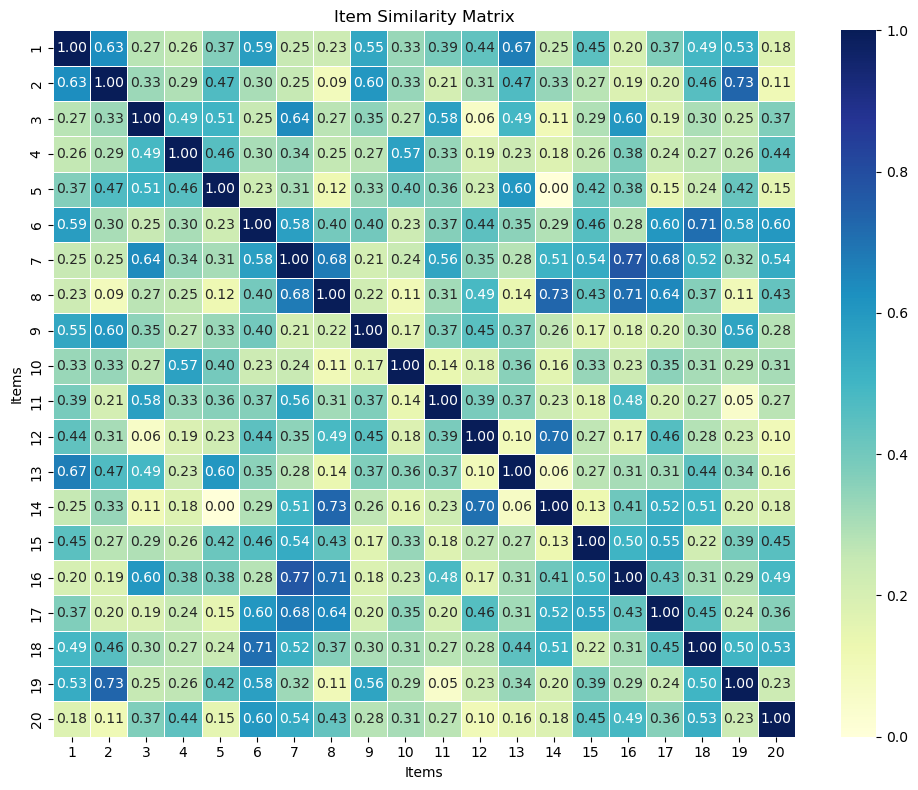

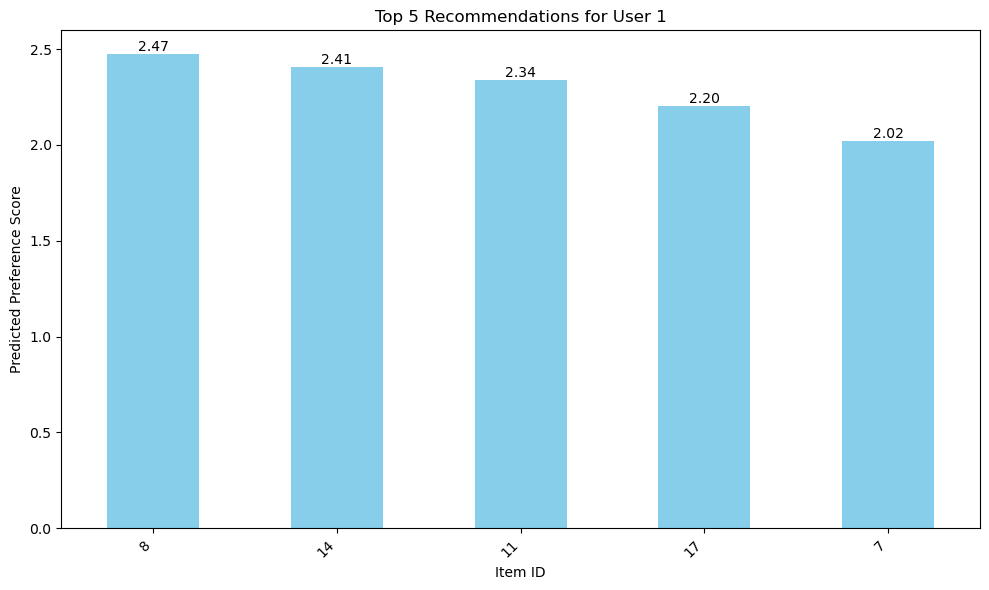

In [ ]:
def item_similarity(matrix):
    """Calculate item-item similarity matrix using cosine similarity"""
    # Convert to numpy array for calculations
    matrix_np = matrix.values
    
    # Initialize similarity matrix
    n_items = matrix_np.shape[1]
    sim_matrix = np.zeros((n_items, n_items))
    
    # Calculate cosine similarity
    for i in range(n_items):
        for j in range(n_items):
            # Get vectors for items i and j
            item_i = matrix_np[:, i]
            item_j = matrix_np[:, j]
            
            # Calculate cosine similarity
            dot_product = np.dot(item_i, item_j)
            norm_i = np.linalg.norm(item_i)
            norm_j = np.linalg.norm(item_j)
            
            # Avoid division by zero
            if norm_i == 0 or norm_j == 0:
                sim_matrix[i, j] = 0
            else:
                sim_matrix[i, j] = dot_product / (norm_i * norm_j)
    
    # Convert to DataFrame with item labels
    sim_df = pd.DataFrame(
        sim_matrix,
        index=matrix.columns,
        columns=matrix.columns
    )
    
    return sim_df

# Calculate similarity matrix
sim_matrix = item_similarity(mat)

# Create heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_matrix,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Item Similarity Matrix")
plt.xlabel("Items")
plt.ylabel("Items")
plt.tight_layout()
plt.show()

def cf_scores_for_user(user_id, top_k=5, matrix=None, sim_matrix=None):
    """Calculate recommendation scores for a specific user"""
    if matrix is None:
        matrix = user_item_matrix()
    if sim_matrix is None:
        sim_matrix = item_similarity(matrix)
    
    # Get user's interaction history
    user_history = matrix.loc[user_id]
    
    # Calculate predicted scores
    scores = pd.Series(np.zeros(len(matrix.columns)), index=matrix.columns)
    
    for item_id in matrix.columns:
        # Skip if user already interacted with the item
        if user_history[item_id] > 0:
            continue
            
        # Get similar items the user has interacted with
        similar_items = sim_matrix[item_id]
        interacted_items = user_history[user_history > 0].index
        
        if len(interacted_items) == 0:
            continue
            
        # Calculate predicted score
        weighted_sum = sum(similar_items[i] * user_history[i] for i in interacted_items)
        total_similarity = sum(abs(similar_items[i]) for i in interacted_items)
        
        if total_similarity > 0:
            scores[item_id] = weighted_sum / total_similarity
    
    # Return top-k recommendations
    return scores.sort_values(ascending=False).head(top_k)

# Create matrices first
mat = user_item_matrix()
sim_matrix = item_similarity(mat)

# Get recommendations for a specific user
user_id = 1  # Change this to test different users
top_k = 5

# Get the recommended scores
scores = cf_scores_for_user(user_id, top_k, mat, sim_matrix)

# Visualize recommendations
plt.figure(figsize=(10, 6))
ax = scores.plot(kind='bar', color='skyblue')
plt.title(f"Top {top_k} Recommendations for User {user_id}")
plt.xlabel("Item ID")
plt.ylabel("Predicted Preference Score")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(scores):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()